In [5]:
import time
import os
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from bs4 import BeautifulSoup
import re
from fractions import Fraction

chrome_path = "chromedriver.exe"
url = 'https://www.koreabaseball.com/record/player/hitterbasic/basic1.aspx'

service = Service(chrome_path)
driver = webdriver.Chrome(service=service)

driver.get(url)
time.sleep(2)

def find_team_dropdown():
    return WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.ID, 'cphContents_cphContents_cphContents_ddlTeam_ddlTeam'))
    )

def select_team(i):
    team_dropdown = find_team_dropdown()
    select = Select(team_dropdown)
    select.select_by_index(i)
    team_name = select.options[i].text
    print(f"선택한 팀: {team_name}")
    time.sleep(2)
    return team_name

def create_directory():
    f_dir = './'
    sec_name = 'Player_Stats'
    os.makedirs(f_dir + sec_name, exist_ok=True)
    return f_dir + sec_name + '\\'

def extract_player_data(tab_name, page):
    soup = BeautifulSoup(driver.page_source, 'html.parser')
    table = soup.find('table')
    
    if table:
        headers = [th.get_text().strip() for th in table.find_all('th')]
        rows = table.find_all('tr')[1:]

        data = []
        for row in rows:
            cols = row.find_all('td')
            player_data = []
            for i, col in enumerate(cols):
                text = col.get_text().strip()
                if 3 <= i <= 18:
                    if text == '-' or text == '':
                        text = 0
                    else:
                        try:
                            if tab_name == '타자' and page == 1:
                                if i == 3:
                                    text = float(text)
                                else:
                                    text = int(text)
                            elif tab_name == '타자' and page == 2:
                                if i in [3, 9, 10, 11, 13, 14]:
                                    text = float(text)
                                else:
                                    text = int(text)
                            elif tab_name == '투수' and page == 1:
                                if i in [3, 9, 18]:
                                    text = float(text)
                                elif i == 10:
                                    text = fraction_to_float(text)
                                else:
                                    text = int(text)
                            elif tab_name == '투수' and page == 2:
                                if i in [3, 10]:
                                    text = float(text)
                                else:
                                    text = int(text)
                            elif tab_name == '수비':
                                if i == 3:
                                    text = text
                                elif i == 6:
                                    text = fraction_to_float(text)
                                elif i == 12 or i == 16:
                                    text = float(text)
                                else :
                                    text = int(text)
                            elif tab_name == '주루':
                                if i == 7:
                                    text = float(text)
                                else :
                                    text = int(text)
                            
                        except ValueError:
                            text = 0
                player_data.append(text)
            data.append(player_data)
        return data, headers
    return [], []

def fraction_to_float(fraction_str):
    parts = fraction_str.split()
    whole_number = int(parts[0])
    fraction_part = parts[1] if len(parts) > 1 else "0"
    fraction = Fraction(fraction_part)
    result = round(float(whole_number + fraction), 2)
    return result

def save_data_to_excel(tab_name, team_name, page):
    dir_path = create_directory()

    player_data, player_headers = extract_player_data(tab_name, page)

    if player_data:
        df = pd.DataFrame(player_data, columns=player_headers)

        file_name = f"{tab_name}{page}_{team_name}.xlsx"
        file_path = os.path.join(dir_path, file_name)

        df.to_excel(file_path, index=False, engine='openpyxl')
        print(f"엑셀 파일 저장 경로: {file_path}")

def click_next_page():
    try:
        next_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'next'))
        )
        next_button.click()
        time.sleep(2)
    except Exception as e:
        print(f"다음 페이지로 이동 중 오류 발생: {e}")

def click_prev_page():
    try:
        prev_button = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.CLASS_NAME, 'prev'))
        )
        prev_button.click()
        time.sleep(2)
    except Exception as e:
        print(f"이전 페이지로 이동 중 오류 발생: {e}")

def process_team(tab_name):
    for i in range(1, 11):  
        try:
            team_name = select_team(i)

            save_data_to_excel(tab_name, team_name, page=1)

            if tab_name in ['타자', '투수']: 
                click_next_page()
                save_data_to_excel(tab_name, team_name, page=2)
                click_prev_page() 

        except Exception as e:
            print(f"오류 발생: {e}")

def click_tabs_and_select_teams():
    try:
        hitter_tab = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//ul[@class='tab']/li/a[@href='/Record/Player/HitterBasic/Basic1.aspx']"))
        )
        hitter_tab.click()
        time.sleep(2)

        process_team('타자')

    except Exception as e:
        print(f"타자 탭 처리 중 오류 발생: {e}")

    try:
        pitcher_tab = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//ul[@class='tab']/li/a[@href='/Record/Player/PitcherBasic/Basic1.aspx']"))
        )
        pitcher_tab.click()
        time.sleep(2)

        process_team('투수')

    except Exception as e:
        print(f"투수 탭 처리 중 오류 발생: {e}")
    
    try:
        defense_tab = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//ul[@class='tab']/li/a[contains(text(),'수비')]"))
        )
        defense_tab.click()
        time.sleep(2)

        process_team('수비')

    except Exception as e:
        print(f"수비 탭 처리 중 오류 발생: {e}")

    try:
        runner_tab = WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//ul[@class='tab']/li/a[contains(text(),'주루')]"))
        )
        runner_tab.click()
        time.sleep(2)

        process_team('주루')
    
    except Exception as e:
        print(f"주루 탭 처리 중 오류 발생: {e}")

click_tabs_and_select_teams()

driver.quit()


선택한 팀: KIA
엑셀 파일 저장 경로: ./Player_Stats\타자1_KIA.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_KIA.xlsx
선택한 팀: 삼성
엑셀 파일 저장 경로: ./Player_Stats\타자1_삼성.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_삼성.xlsx
선택한 팀: LG
엑셀 파일 저장 경로: ./Player_Stats\타자1_LG.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_LG.xlsx
선택한 팀: 두산
엑셀 파일 저장 경로: ./Player_Stats\타자1_두산.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_두산.xlsx
선택한 팀: KT
엑셀 파일 저장 경로: ./Player_Stats\타자1_KT.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_KT.xlsx
선택한 팀: SSG
엑셀 파일 저장 경로: ./Player_Stats\타자1_SSG.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_SSG.xlsx
선택한 팀: 롯데
엑셀 파일 저장 경로: ./Player_Stats\타자1_롯데.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_롯데.xlsx
선택한 팀: 한화
엑셀 파일 저장 경로: ./Player_Stats\타자1_한화.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_한화.xlsx
선택한 팀: NC
엑셀 파일 저장 경로: ./Player_Stats\타자1_NC.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_NC.xlsx
선택한 팀: 키움
엑셀 파일 저장 경로: ./Player_Stats\타자1_키움.xlsx
엑셀 파일 저장 경로: ./Player_Stats\타자2_키움.xlsx
선택한 팀: KIA
엑셀 파일 저장 경로: ./Player_Stats\투수1_KIA.xlsx
엑셀 파일 저장 경로: ./Player_Stats\투수2_KIA.xlsx
선

In [161]:
import glob
import pandas as pd

hitter1_files = glob.glob('Player_Stats/타자1_*.xlsx')
hitter2_files = glob.glob('Player_Stats/타자2_*.xlsx')

hitter1_data = []
hitter2_data = []

for file in hitter1_files:
    try:
        df = pd.read_excel(file)
        hitter1_data.append(df)
    except Exception as e:
        print(f"타자1 파일 읽기 중 오류 발생: {file}, 오류: {e}")

for file in hitter2_files:
    try:
        df = pd.read_excel(file)
        hitter2_data.append(df)
    except Exception as e:
        print(f"타자2 파일 읽기 중 오류 발생: {file}, 오류: {e}")

# 데이터 결합
hitter1_df = pd.concat(hitter1_data, ignore_index=True)
hitter2_df = pd.concat(hitter2_data, ignore_index=True)
hitter_combined = pd.merge(hitter1_df, hitter2_df, on=['선수명', '팀명'], suffixes=('_1', '_2'))

hitter_combined = hitter_combined.drop(columns=['순위_1', '순위_2', 'AVG_2'])
hitter_combined = hitter_combined.rename(columns={
    'AVG_1': 'AVG',     
    '팀명': 'Team',
    '선수명': 'Name'
})

hitter_combined


,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,IBB,HBP,SO,GDP,SLG,OBP,OPS,MH,RISP,PH-BA
0,윤도현,KIA,0.407,6,27,27,5,11,2,0,...,0,0,9,0,0.593,0.407,1.000,5,0.500,0.000
1,김두현,KIA,0.400,3,6,5,2,2,0,0,...,0,1,0,0,0.400,0.500,0.900,0,0.000,0.000
2,김도영,KIA,0.347,141,625,544,143,189,29,10,...,7,7,110,10,0.647,0.420,1.067,58,0.317,0.500
3,김선빈,KIA,0.329,116,466,423,48,139,23,0,...,0,5,39,13,0.447,0.380,0.827,42,0.350,0.500
4,서건창,KIA,0.310,94,248,203,40,63,14,1,...,0,3,31,2,0.404,0.416,0.820,11,0.344,0.346
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,이명기,한화,0.000,4,8,7,0,0,0,0,...,0,0,3,0,0.000,0.000,0.000,0,0.000,0.000
296,장규현,한화,0.000,9,7,6,0,0,0,0,...,0,0,1,0,0.000,0.143,0.143,0,0.000,0.000
297,장민재,한화,0.000,1,0,0,0,0,0,0,...,0,0,0,0,0.000,0.000,0.000,0,0.000,0.000
298,주현상,한화,0.000,2,0,0,0,0,0,0,...,0,0,0,0,0.000,0.000,0.000,0,0.000,0.000


In [207]:
defend_files = glob.glob('Player_Stats/수비1_*.xlsx')

defend_data = []

for file in defend_files:
    try:
        df = pd.read_excel(file)
        defend_data.append(df)
    except Exception as e:
        print(f"수비1 파일 읽기 중 오류 발생: {file}, 오류: {e}")

# 데이터 결합
defend_df = pd.concat(defend_data, ignore_index=True)


defend_df = defend_df.drop(columns=['순위', 'G'])
defend_df = defend_df.rename(columns={ 
    '팀명': 'Team',
    '선수명': 'Name'
})

defend_df

,Name,Team,POS,GS,IP,E,PKO,PO,A,DP,FPCT,PB,SB,CS,CS%
0,김도영,KIA,3루수,132,1111.00,30,0,77,216,26,0.907,0,0,0,0.0
1,박찬호,KIA,유격수,129,1120.33,23,0,213,328,72,0.959,0,0,0,0.0
2,김선빈,KIA,2루수,112,884.00,10,0,206,284,66,0.980,0,0,0,0.0
3,소크라테스,KIA,좌익수,86,755.33,2,0,168,4,1,0.989,0,0,0,0.0
4,한준수,KIA,포수,60,600.00,4,1,541,39,6,0.993,6,47,11,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,황준서,한화,투수,11,72.00,1,1,0,10,1,0.909,0,0,0,0.0
296,김강민,한화,중견수,15,153.33,0,0,40,0,0,1.000,0,0,0,0.0
297,장시환,한화,투수,0,33.33,1,0,1,4,0,0.833,0,0,0,0.0
298,류현진,한화,투수,28,158.33,1,0,1,25,1,0.963,0,0,0,0.0


In [209]:
running_files = glob.glob('Player_Stats/주루1_*.xlsx')

running_data = []

for file in running_files:
    try:
        df = pd.read_excel(file)
        running_data.append(df)
    except Exception as e:
        print(f"주루1 파일 읽기 중 오류 발생: {file}, 오류: {e}")

# 데이터 결합
running_df = pd.concat(running_data, ignore_index=True)

running_df = running_df.drop(columns=['순위', 'G'])
running_df = running_df.rename(columns={ 
    '팀명': 'Team',
    '선수명': 'Name'
})

running_df

,Name,Team,SBA,SB,CS,SB%,OOB,PKO
0,김도영,KIA,44,40,4,90.9,5,1
1,최원준,KIA,30,21,9,70.0,3,1
2,박찬호,KIA,33,20,13,60.6,4,1
3,소크라테스,KIA,18,13,5,72.2,11,1
4,이우성,KIA,8,7,1,87.5,5,0
...,...,...,...,...,...,...,...,...
295,장규현,한화,0,0,0,0.0,0,0
296,장민재,한화,0,0,0,0.0,0,0
297,주현상,한화,0,0,0,0.0,0,0
298,최재훈,한화,0,0,0,0.0,1,0


In [211]:
running_combined = pd.merge(hitter_combined, running_df, on=['Name', 'Team'], suffixes=('_1', '_2'))
running_combined

,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,OPS,MH,RISP,PH-BA,SBA,SB,CS,SB%,OOB,PKO
0,윤도현,KIA,0.407,6,27,27,5,11,2,0,...,1.000,5,0.500,0.000,1,1,0,100.0,0,0
1,김두현,KIA,0.400,3,6,5,2,2,0,0,...,0.900,0,0.000,0.000,0,0,0,0.0,0,0
2,김도영,KIA,0.347,141,625,544,143,189,29,10,...,1.067,58,0.317,0.500,44,40,4,90.9,5,1
3,김선빈,KIA,0.329,116,466,423,48,139,23,0,...,0.827,42,0.350,0.500,6,5,1,83.3,1,0
4,서건창,KIA,0.310,94,248,203,40,63,14,1,...,0.820,11,0.344,0.346,4,3,1,75.0,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
253,이명기,한화,0.000,4,8,7,0,0,0,0,...,0.000,0,0.000,0.000,0,0,0,0.0,0,0
254,장규현,한화,0.000,9,7,6,0,0,0,0,...,0.143,0,0.000,0.000,0,0,0,0.0,0,0
255,장민재,한화,0.000,1,0,0,0,0,0,0,...,0.000,0,0.000,0.000,0,0,0,0.0,0,0
256,주현상,한화,0.000,2,0,0,0,0,0,0,...,0.000,0,0.000,0.000,0,0,0,0.0,0,0


In [227]:
combined = pd.merge(running_combined, defend_df, on=['Name', 'Team'], suffixes=('_1', '_2'))
combined

,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,E,PKO_2,PO,A,DP,FPCT,PB,SB_2,CS_2,CS%
0,김도영,KIA,0.347,141,625,544,143,189,29,10,...,30,0,77,216,26,0.907,0,0,0,0.0
1,김선빈,KIA,0.329,116,466,423,48,139,23,0,...,10,0,206,284,66,0.980,0,0,0,0.0
2,서건창,KIA,0.310,94,248,203,40,63,14,1,...,4,0,241,30,22,0.985,0,0,0,0.0
3,서건창,KIA,0.310,94,248,203,40,63,14,1,...,1,0,34,51,11,0.988,0,0,0,0.0
4,소크라테스,KIA,0.310,140,602,552,92,171,30,3,...,2,0,168,4,1,0.989,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,이원석,한화,0.233,87,154,133,26,31,4,1,...,0,0,62,0,0,1.000,0,0,0,0.0
186,김강민,한화,0.224,41,87,76,5,17,0,0,...,0,0,40,0,0,1.000,0,0,0,0.0
187,김서현,한화,0.000,1,0,0,0,0,0,0,...,0,0,0,5,0,1.000,0,0,0,0.0
188,박상원,한화,0.000,2,0,0,0,0,0,0,...,1,1,2,3,0,0.833,0,0,0,0.0


In [229]:
x = combined[combined['POS']=='투수']
x

,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,E,PKO_2,PO,A,DP,FPCT,PB,SB_2,CS_2,CS%
18,곽도규,KIA,0.0,1,0,0,0,0,0,0,...,3,0,3,7,0,0.769,0,0,0,0.0
49,김대현,LG,0.0,3,0,0,0,0,0,0,...,0,0,0,1,0,1.000,0,0,0,0.0
50,김유영,LG,0.0,2,0,0,0,0,0,0,...,3,0,0,6,1,0.667,0,0,0,0.0
70,김영규,NC,0.0,1,0,0,0,0,0,0,...,1,2,2,8,0,0.909,0,0,0,0.0
71,김재열,NC,0.0,1,0,0,0,0,0,0,...,2,0,3,5,0,0.800,0,0,0,0.0
72,류진욱,NC,0.0,1,0,0,0,0,0,0,...,1,0,6,5,0,0.917,0,0,0,0.0
73,송명기,NC,0.0,1,0,0,0,0,0,0,...,0,0,0,1,0,1.000,0,0,0,0.0
90,문승원,SSG,0.0,6,1,1,0,0,0,0,...,0,0,2,9,1,1.000,0,0,0,0.0
91,이로운,SSG,0.0,3,0,0,0,0,0,0,...,0,0,1,3,0,1.000,0,0,0,0.0
92,조병현,SSG,0.0,3,0,0,0,0,0,0,...,2,0,6,2,0,0.800,0,0,0,0.0


In [231]:
combined = combined[combined['POS'] != '투수']
combined

,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,E,PKO_2,PO,A,DP,FPCT,PB,SB_2,CS_2,CS%
0,김도영,KIA,0.347,141,625,544,143,189,29,10,...,30,0,77,216,26,0.907,0,0,0,0.0
1,김선빈,KIA,0.329,116,466,423,48,139,23,0,...,10,0,206,284,66,0.980,0,0,0,0.0
2,서건창,KIA,0.310,94,248,203,40,63,14,1,...,4,0,241,30,22,0.985,0,0,0,0.0
3,서건창,KIA,0.310,94,248,203,40,63,14,1,...,1,0,34,51,11,0.988,0,0,0,0.0
4,소크라테스,KIA,0.310,140,602,552,92,171,30,3,...,2,0,168,4,1,0.989,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,장진혁,한화,0.263,99,327,289,56,76,16,0,...,1,0,142,1,0,0.993,0,0,0,0.0
183,최재훈,한화,0.257,116,348,280,34,72,10,0,...,5,3,746,60,6,0.994,5,58,23,28.4
184,이재원,한화,0.239,72,152,134,10,32,4,0,...,1,0,304,27,3,0.997,6,31,12,27.9
185,이원석,한화,0.233,87,154,133,26,31,4,1,...,0,0,62,0,0,1.000,0,0,0,0.0


In [233]:
# 40경기 이상 출전 선수 추출
hitter = combined[combined['G'] >= 40]

hitter

,Name,Team,AVG,G,PA,AB,R,H,2B,3B,...,E,PKO_2,PO,A,DP,FPCT,PB,SB_2,CS_2,CS%
0,김도영,KIA,0.347,141,625,544,143,189,29,10,...,30,0,77,216,26,0.907,0,0,0,0.0
1,김선빈,KIA,0.329,116,466,423,48,139,23,0,...,10,0,206,284,66,0.980,0,0,0,0.0
2,서건창,KIA,0.310,94,248,203,40,63,14,1,...,4,0,241,30,22,0.985,0,0,0,0.0
3,서건창,KIA,0.310,94,248,203,40,63,14,1,...,1,0,34,51,11,0.988,0,0,0,0.0
4,소크라테스,KIA,0.310,140,602,552,92,171,30,3,...,2,0,168,4,1,0.989,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,장진혁,한화,0.263,99,327,289,56,76,16,0,...,1,0,142,1,0,0.993,0,0,0,0.0
183,최재훈,한화,0.257,116,348,280,34,72,10,0,...,5,3,746,60,6,0.994,5,58,23,28.4
184,이재원,한화,0.239,72,152,134,10,32,4,0,...,1,0,304,27,3,0.997,6,31,12,27.9
185,이원석,한화,0.233,87,154,133,26,31,4,1,...,0,0,62,0,0,1.000,0,0,0,0.0


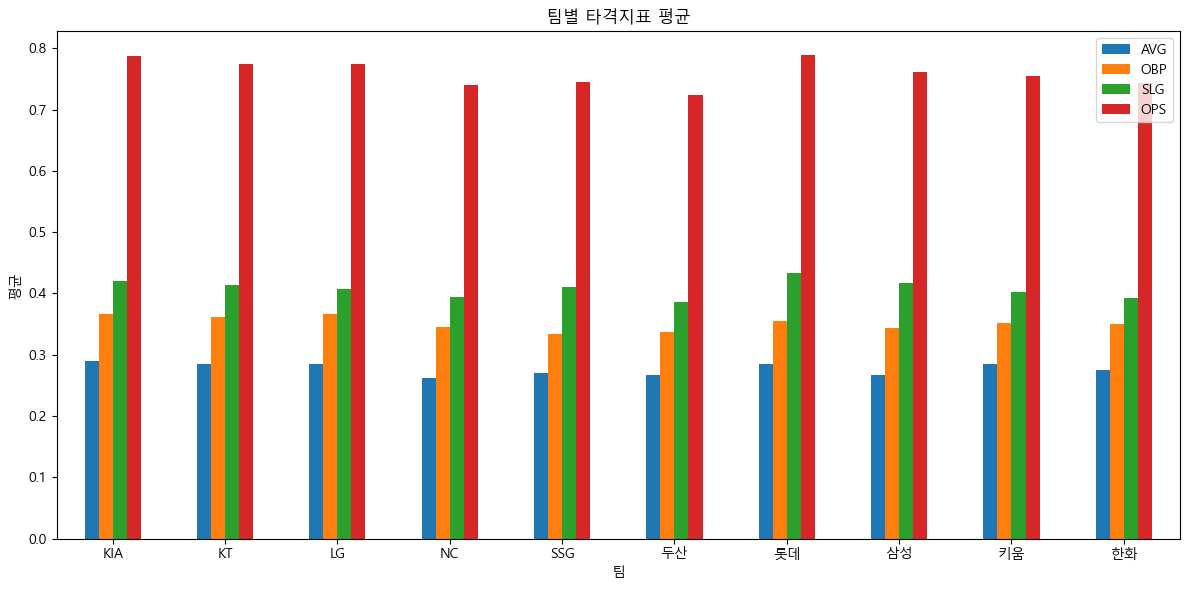

In [235]:
# 팀별 평균 AVG, OBP, SLG, OPS

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

team_stats = hitter.groupby('Team')[['AVG', 'OBP', 'SLG', 'OPS']].mean()

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

team_stats.plot(kind='bar', figsize=(12, 6))
plt.title('팀별 타격지표 평균')
plt.ylabel('평균')
plt.xlabel('팀')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

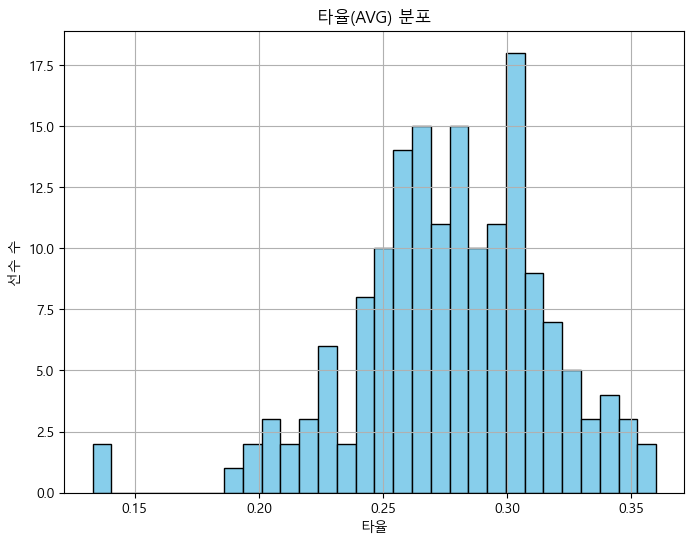

In [237]:
# 타율(AVG) 분포
plt.figure(figsize=(8, 6))
plt.hist(hitter['AVG'], bins=30, color='skyblue', edgecolor='black') 
plt.title('타율(AVG) 분포')
plt.xlabel('타율')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

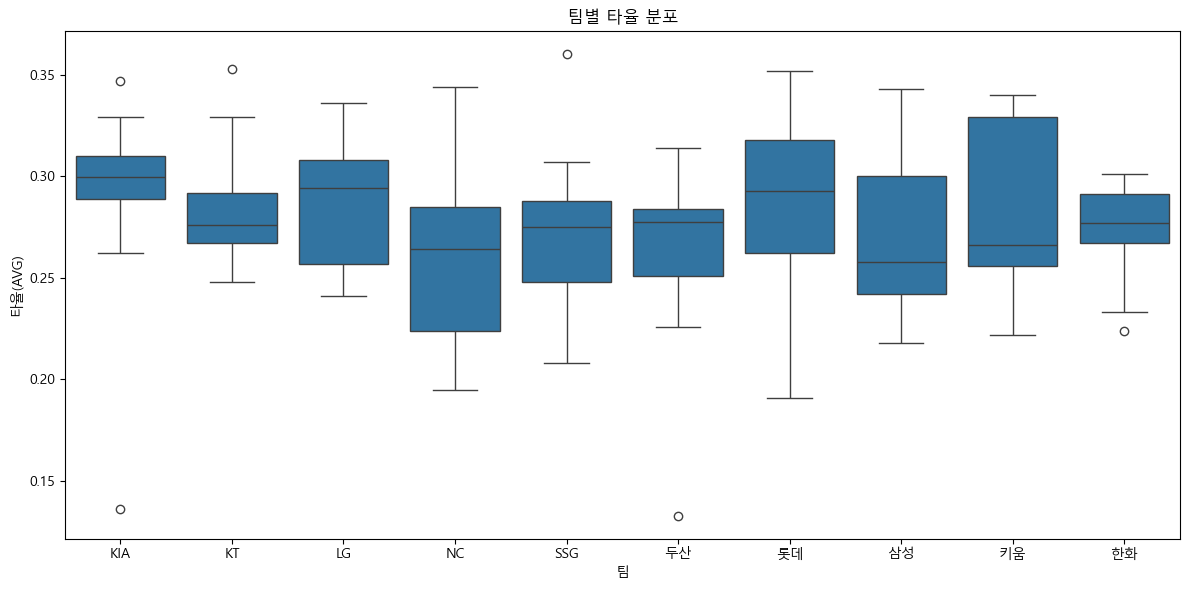

In [239]:
# 팀별 타율 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='AVG', data=hitter)
plt.title('팀별 타율 분포')
plt.xlabel('팀')
plt.ylabel('타율(AVG)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

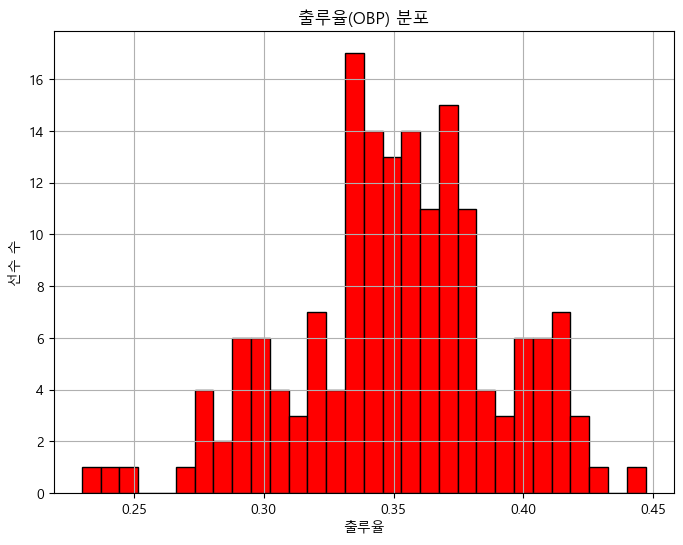

In [241]:
# 출루율(OBP) 분포
plt.figure(figsize=(8, 6))
plt.hist(hitter['OBP'], bins=30, color='red', edgecolor='black') 
plt.title('출루율(OBP) 분포')
plt.xlabel('출루율')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

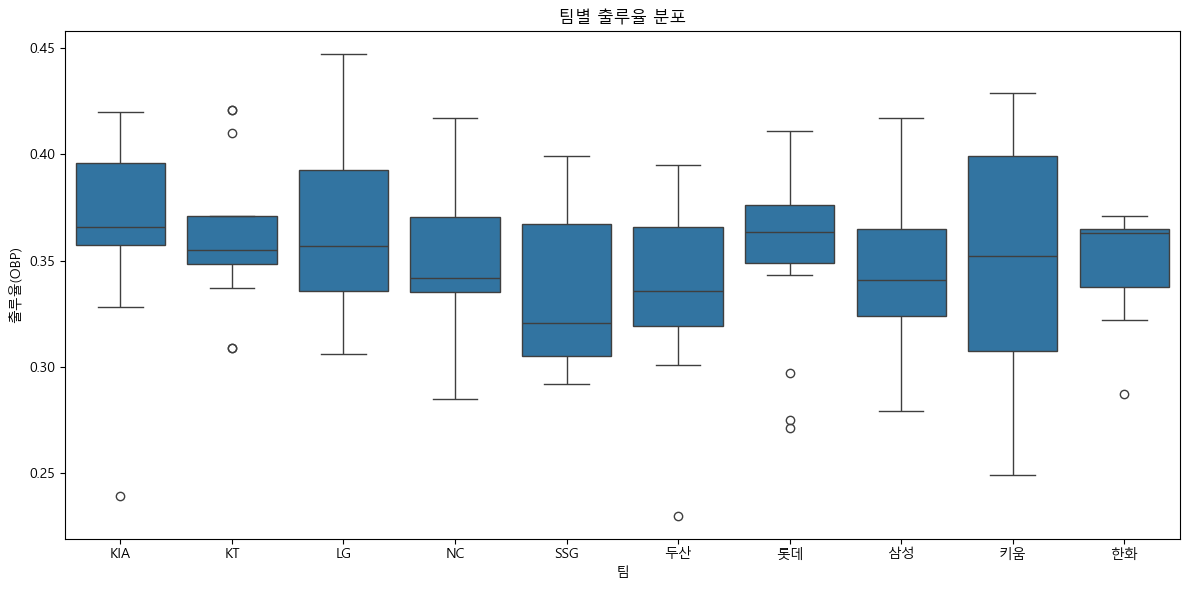

In [243]:
# 팀별 출루율 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='OBP', data=hitter)
plt.title('팀별 출루율 분포')
plt.xlabel('팀')
plt.ylabel('출루율(OBP)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

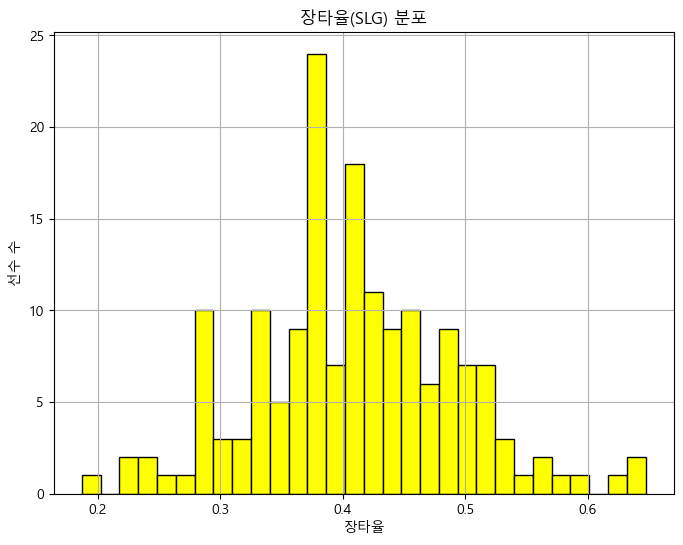

In [245]:
# 장타율(SLG) 분포
plt.figure(figsize=(8, 6))
plt.hist(hitter['SLG'], bins=30, color='yellow', edgecolor='black') 
plt.title('장타율(SLG) 분포')
plt.xlabel('장타율')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

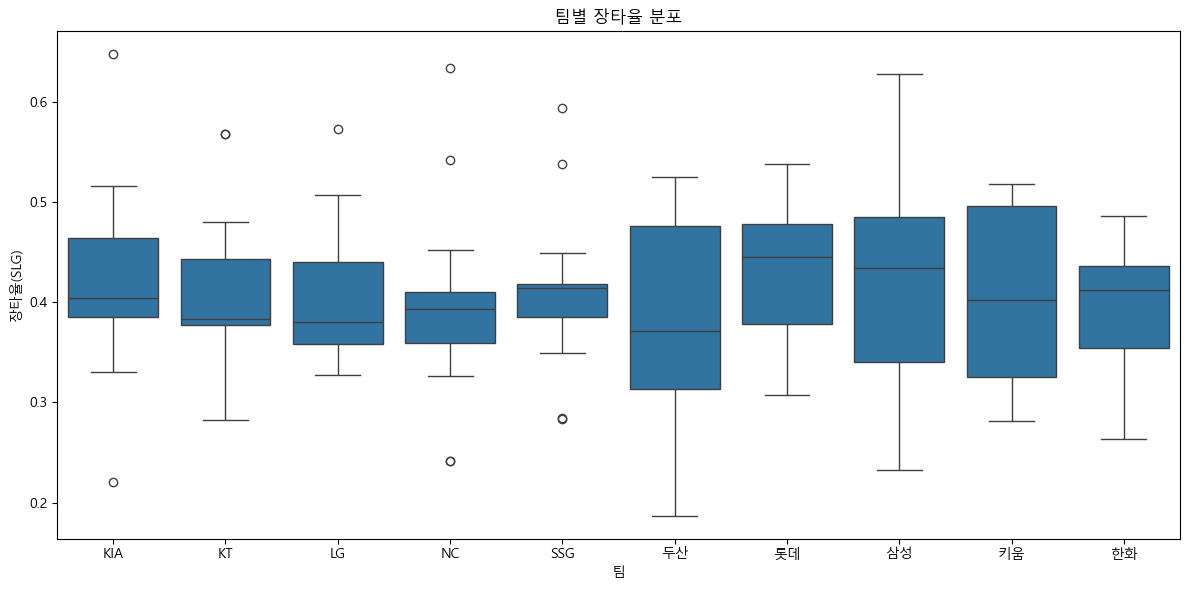

In [247]:
# 팀별 장타율 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='SLG', data=hitter)
plt.title('팀별 장타율 분포')
plt.xlabel('팀')
plt.ylabel('장타율(SLG)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

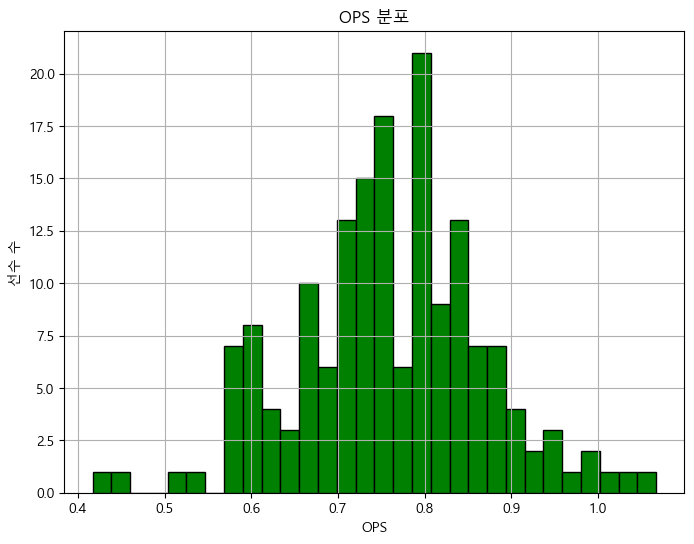

In [249]:
# OPS 분포
plt.figure(figsize=(8, 6))
plt.hist(hitter['OPS'], bins=30, color='green', edgecolor='black') 
plt.title('OPS 분포')
plt.xlabel('OPS')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

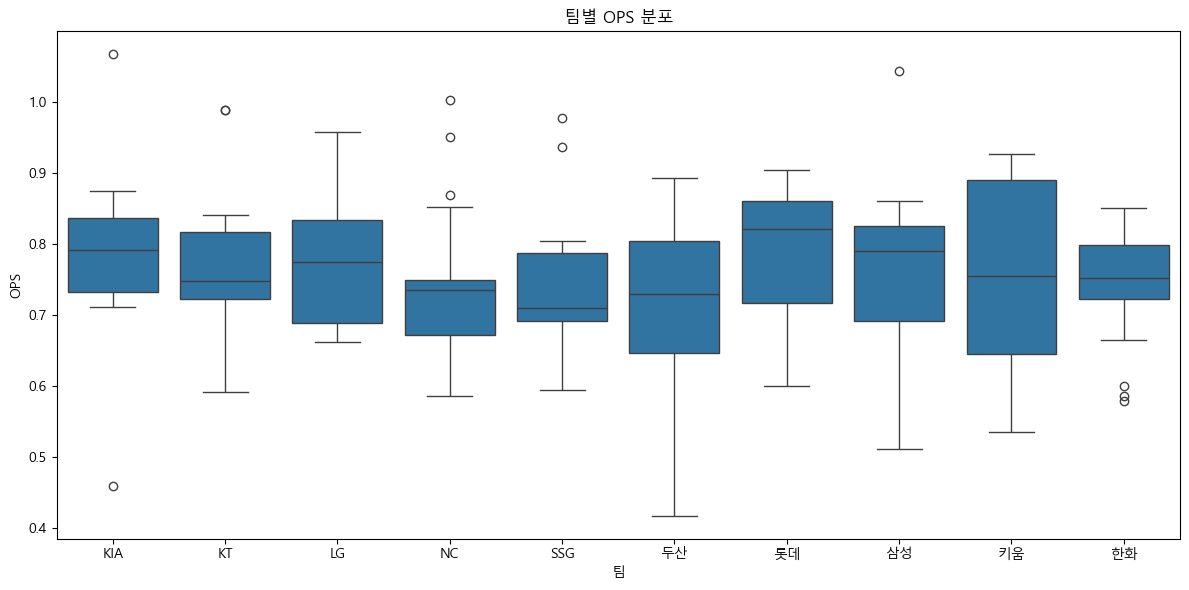

In [251]:
# 팀별 OPS 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='OPS', data=hitter)
plt.title('팀별 OPS 분포')
plt.xlabel('팀')
plt.ylabel('OPS')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

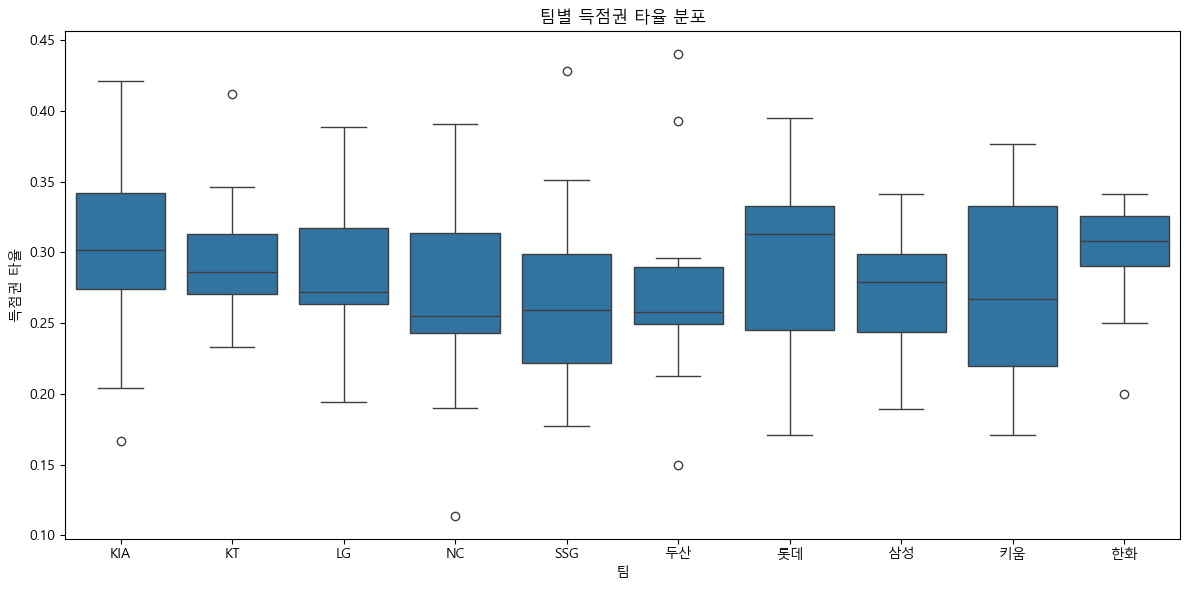

In [253]:
# 팀별 득점권 타율 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='RISP', data=hitter)
plt.title('팀별 득점권 타율 분포')
plt.xlabel('팀')
plt.ylabel('득점권 타율')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

C:\Users\jun05\AppData\Local\Temp\ipykernel_3120\2443483948.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hitter['BB_to_SO'] = hitter['BB'] / hitter['SO']


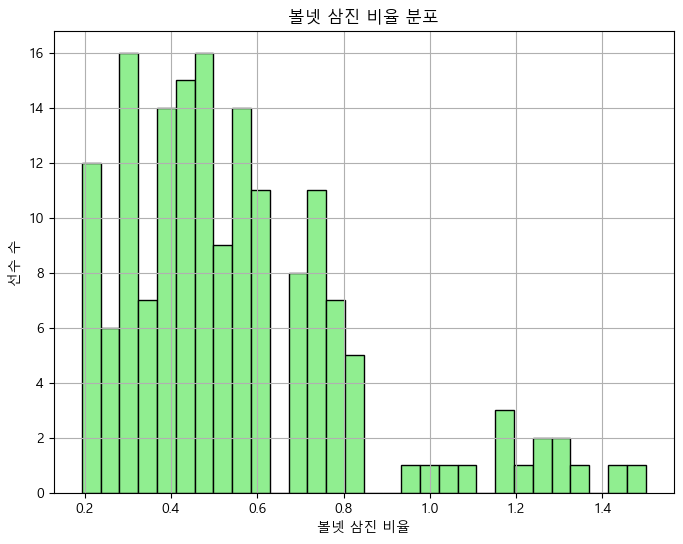

In [255]:
# 볼넷 대비 삼진 비율 계산 (BB:SO)
hitter['BB_to_SO'] = hitter['BB'] / hitter['SO']

hitter[['Name', 'BB', 'SO', 'BB_to_SO']].head()

# 볼넷 삼진 비율 분포 
plt.figure(figsize=(8, 6))
plt.hist(hitter['BB_to_SO'], bins=30, color='lightgreen', edgecolor='black')
plt.title('볼넷 삼진 비율 분포')
plt.xlabel('볼넷 삼진 비율')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

In [257]:
# 팀별 타율 상위 선수 수

top_20_percent_avg = hitter[hitter['AVG'] >= hitter['AVG'].quantile(0.8)]

top_20_percent_avg['Team'].value_counts()


Team
KIA    8
롯데     7
키움     5
LG     4
KT     3
NC     2
SSG    2
두산     2
삼성     2
Name: count, dtype: int64

In [259]:
# 팀별 홈런 상위 선수 수

top_20_percent_avg = hitter[hitter['HR'] >= hitter['HR'].quantile(0.8)]

top_20_percent_avg['Team'].value_counts()


Team
삼성     7
KT     5
두산     5
KIA    4
LG     4
NC     4
한화     4
SSG    2
롯데     2
키움     2
Name: count, dtype: int64

In [275]:
c = hitter[hitter['POS']=='포수']
c = c[['Name', 'Team', 'CS%', 'E', 'AVG', 'OPS']]
c

,Name,Team,CS%,E,AVG,OPS
14,김태군,KIA,15.5,6,0.264,0.711
23,강백호,KT,20.0,2,0.289,0.840
29,장성우,KT,14.9,2,0.268,0.805
42,박동원,LG,25.0,4,0.272,0.810
60,박세혁,NC,13.2,3,0.264,0.682
69,김형준,NC,37.8,12,0.195,0.658
78,이지영,SSG,23.0,7,0.279,0.669
87,김민식,SSG,8.3,0,0.208,0.594
93,양의지,두산,13.6,4,0.314,0.858
101,김기연,두산,14.3,2,0.278,0.714


In [281]:
c.sort_values(by='AVG', ascending=False).head(4)

,Name,Team,CS%,E,AVG,OPS
93,양의지,두산,13.6,4,0.314,0.858
131,강민호,삼성,23.4,2,0.303,0.861
23,강백호,KT,20.0,2,0.289,0.840
78,이지영,SSG,23.0,7,0.279,0.669


In [289]:
c.sort_values(by='OPS', ascending=False).head(4)

,Name,Team,CS%,E,AVG,OPS
131,강민호,삼성,23.4,2,0.303,0.861
93,양의지,두산,13.6,4,0.314,0.858
23,강백호,KT,20.0,2,0.289,0.840
42,박동원,LG,25.0,4,0.272,0.810


In [287]:
c['E'].mean()

4.0

In [331]:
entry = []

entry_c = ['강민호', '양의지']
# AVG, OPS 모두 상위권, 실책 많지 않음, 양의지는 CS% 낮지만 AVG, OPS가 더 중요

entry = entry + entry_c

entry

['강민호', '양의지']

In [307]:
first = hitter[hitter['POS']=='1루수']
first = first[['Name', 'Team','G', 'AVG', 'OPS', 'SLG', 'OBP','SB_1', 'E']]
first

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
2,서건창,KIA,94,0.310,0.820,0.404,0.416,3,4
8,변우혁,KIA,69,0.304,0.839,0.470,0.369,1,2
13,이우성,KIA,112,0.288,0.762,0.401,0.361,7,6
32,문상철,KT,125,0.256,0.786,0.435,0.351,6,6
35,오스틴,LG,140,0.319,0.957,0.573,0.384,12,8
39,문보경,LG,144,0.301,0.879,0.507,0.372,7,3
48,김범석,LG,70,0.241,0.683,0.377,0.306,0,3
53,데이비슨,NC,131,0.306,1.003,0.633,0.370,0,11
65,도태훈,NC,100,0.214,0.586,0.241,0.345,1,1
81,오태곤,SSG,117,0.275,0.804,0.449,0.355,27,2


In [313]:
first.sort_values(by='AVG', ascending=False).head(7)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
151,송성문,키움,142,0.340,0.927,0.518,0.409,21,1
35,오스틴,LG,140,0.319,0.957,0.573,0.384,12,8
116,나승엽,롯데,121,0.312,0.880,0.469,0.411,1,11
2,서건창,KIA,94,0.310,0.820,0.404,0.416,3,4
53,데이비슨,NC,131,0.306,1.003,0.633,0.370,0,11
8,변우혁,KIA,69,0.304,0.839,0.470,0.369,1,2
39,문보경,LG,144,0.301,0.879,0.507,0.372,7,3


In [315]:
first.sort_values(by='OPS', ascending=False).head(7)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
53,데이비슨,NC,131,0.306,1.003,0.633,0.370,0,11
35,오스틴,LG,140,0.319,0.957,0.573,0.384,12,8
151,송성문,키움,142,0.340,0.927,0.518,0.409,21,1
116,나승엽,롯데,121,0.312,0.880,0.469,0.411,1,11
39,문보경,LG,144,0.301,0.879,0.507,0.372,7,3
8,변우혁,KIA,69,0.304,0.839,0.470,0.369,1,2
142,이성규,삼성,122,0.242,0.839,0.500,0.339,9,2


In [317]:
first['E'].mean()

4.636363636363637

In [333]:
entry_first = ['송성문', '문보경']
# 송성문 : 모든 지표 매우 높음
# 문보경 : 나승엽은 실책이 많아 수비가 안 좋고, 주루도 안 좋다. 출루율 제외 지표가 나승엽 보다 좋다.
# 변우혁 : 게임 수 적다.

entry = entry + entry_first

entry

['강민호', '양의지', '송성문', '문보경']

In [335]:
second = hitter[hitter['POS']=='2루수']
second = second[['Name', 'Team','G', 'AVG', 'OPS', 'SLG', 'OBP','SB_1', 'E']]
second

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
1,김선빈,KIA,116,0.329,0.827,0.447,0.380,5,10
3,서건창,KIA,94,0.310,0.820,0.404,0.416,3,1
9,홍종표,KIA,100,0.295,0.729,0.390,0.339,5,2
22,천성호,KT,75,0.295,0.714,0.368,0.346,7,4
25,신본기,KT,84,0.279,0.748,0.377,0.371,2,3
27,김상수,KT,113,0.276,0.730,0.379,0.351,3,4
40,신민재,LG,128,0.297,0.758,0.357,0.401,32,11
46,구본혁,LG,133,0.257,0.662,0.327,0.335,8,2
52,박민우,NC,121,0.328,0.852,0.446,0.406,32,6
56,서호철,NC,141,0.285,0.735,0.393,0.342,1,5


In [339]:
second.sort_values(by='AVG', ascending=False).head(6)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
1,김선빈,KIA,116,0.329,0.827,0.447,0.380,5,10
52,박민우,NC,121,0.328,0.852,0.446,0.406,32,6
154,김혜성,키움,127,0.326,0.841,0.458,0.383,30,16
3,서건창,KIA,94,0.310,0.820,0.404,0.416,3,1
117,고승민,롯데,120,0.308,0.834,0.476,0.358,5,13
75,정준재,SSG,88,0.307,0.776,0.405,0.371,16,3


In [343]:
second.sort_values(by='OPS', ascending=False).head(5)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
52,박민우,NC,121,0.328,0.852,0.446,0.406,32,6
154,김혜성,키움,127,0.326,0.841,0.458,0.383,30,16
117,고승민,롯데,120,0.308,0.834,0.476,0.358,5,13
1,김선빈,KIA,116,0.329,0.827,0.447,0.380,5,10
3,서건창,KIA,94,0.310,0.820,0.404,0.416,3,1


In [345]:
second['E'].mean()

5.304347826086956

In [347]:
entry_second = ['박민우', '김혜성']
# 박민우 : 모든 지표 매우 높음
# 김혜성 : 타율은 김선빈과 비슷하고 출루율, 장타율, OPS, 주루가 더 좋다. 실책이 많지만 다른 지표가 우선순위

entry = entry + entry_second

entry

['강민호', '양의지', '송성문', '문보경', '박민우', '김혜성']

In [351]:
third = hitter[hitter['POS']=='3루수']
third = third[['Name', 'Team','G', 'AVG', 'OPS', 'SLG', 'OBP','SB_1', 'E']]
third

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
0,김도영,KIA,141,0.347,1.067,0.647,0.420,40,30
31,황재균,KT,137,0.260,0.692,0.383,0.309,4,14
38,문보경,LG,144,0.301,0.879,0.507,0.372,7,10
44,구본혁,LG,133,0.257,0.662,0.327,0.335,8,3
55,서호철,NC,141,0.285,0.735,0.393,0.342,1,9
62,김휘집,NC,140,0.258,0.747,0.410,0.337,4,7
77,최정,SSG,129,0.291,0.978,0.594,0.384,5,13
94,허경민,두산,115,0.309,0.811,0.427,0.384,5,5
103,이유찬,두산,103,0.277,0.705,0.364,0.341,16,2
107,전민재,두산,100,0.246,0.599,0.298,0.301,7,1


In [353]:
third.sort_values(by='AVG', ascending=False).head(6)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
0,김도영,KIA,141,0.347,1.067,0.647,0.420,40,30
150,송성문,키움,142,0.340,0.927,0.518,0.409,21,7
115,손호영,롯데,102,0.317,0.892,0.538,0.354,7,13
94,허경민,두산,115,0.309,0.811,0.427,0.384,5,5
38,문보경,LG,144,0.301,0.879,0.507,0.372,7,10
77,최정,SSG,129,0.291,0.978,0.594,0.384,5,13


In [355]:
third.sort_values(by='OPS', ascending=False).head(6)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
0,김도영,KIA,141,0.347,1.067,0.647,0.420,40,30
77,최정,SSG,129,0.291,0.978,0.594,0.384,5,13
150,송성문,키움,142,0.340,0.927,0.518,0.409,21,7
115,손호영,롯데,102,0.317,0.892,0.538,0.354,7,13
38,문보경,LG,144,0.301,0.879,0.507,0.372,7,10
94,허경민,두산,115,0.309,0.811,0.427,0.384,5,5


In [357]:
entry_third = ['김도영', '최정']
# 김도영 : 모든 지표 매우 높음
# 최정 : 손호영에 비해 OPS, 장타율, 출루율이 매우 높음

entry = entry + entry_third

entry

['강민호', '양의지', '송성문', '문보경', '박민우', '김혜성', '김도영', '최정']

In [359]:
ss = hitter[hitter['POS']=='유격수']
ss = ss[['Name', 'Team','G', 'AVG', 'OPS', 'SLG', 'OBP','SB_1', 'E']]
ss

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
7,박찬호,KIA,134,0.307,0.749,0.386,0.363,20,23
24,신본기,KT,84,0.279,0.748,0.377,0.371,2,4
26,김상수,KT,113,0.276,0.730,0.379,0.351,3,10
30,심우준,KT,53,0.266,0.680,0.343,0.337,7,8
45,구본혁,LG,133,0.257,0.662,0.327,0.335,8,5
47,오지환,LG,108,0.254,0.761,0.411,0.350,17,12
61,김휘집,NC,140,0.258,0.747,0.410,0.337,4,9
63,김주원,NC,134,0.252,0.750,0.379,0.371,16,18
76,박성한,SSG,137,0.301,0.791,0.411,0.380,13,23
96,김재호,두산,57,0.302,0.760,0.365,0.395,0,7


In [361]:
ss.sort_values(by='AVG', ascending=False).head(6)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
7,박찬호,KIA,134,0.307,0.749,0.386,0.363,20,23
96,김재호,두산,57,0.302,0.760,0.365,0.395,0,7
76,박성한,SSG,137,0.301,0.791,0.411,0.380,13,23
169,황영묵,한화,123,0.301,0.737,0.372,0.365,4,4
172,하주석,한화,64,0.292,0.743,0.394,0.349,1,3
24,신본기,KT,84,0.279,0.748,0.377,0.371,2,4


In [363]:
ss.sort_values(by='OPS', ascending=False).head(5)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,E
140,김영웅,삼성,126,0.252,0.806,0.485,0.321,9,5
76,박성한,SSG,137,0.301,0.791,0.411,0.380,13,23
136,이재현,삼성,109,0.260,0.784,0.419,0.365,2,11
47,오지환,LG,108,0.254,0.761,0.411,0.350,17,12
96,김재호,두산,57,0.302,0.760,0.365,0.395,0,7


In [365]:
ss['E'].mean()

9.65

In [367]:
entry_ss = ['박성한', '박찬호']
# 박성한 : 모든 지표 높음
# 박찬호 : 김영웅에 비해 타율이 높고 주루가 좋다.
# 김재호 : 경기수 적음

entry = entry + entry_ss

entry

['강민호', '양의지', '송성문', '문보경', '박민우', '김혜성', '김도영', '최정', '박성한', '박찬호']

In [387]:
f = hitter[(hitter['POS'] == '좌익수') | (hitter['POS'] == '우익수') | (hitter['POS'] == '중견수')]

f = f[['Name', 'Team','G', 'AVG', 'OPS', 'SLG', 'OBP','SB_1', 'RISP', 'BB_to_SO']]
f = f.drop_duplicates()
f

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
4,소크라테스,KIA,140,0.310,0.875,0.516,0.359,13,0.336,0.450549
6,박정우,KIA,66,0.308,0.733,0.385,0.348,0,0.421,0.285714
10,최원준,KIA,136,0.292,0.791,0.420,0.371,21,0.301,0.757576
12,나성범,KIA,102,0.291,0.868,0.511,0.357,0,0.299,0.387755
15,이창진,KIA,103,0.262,0.731,0.330,0.401,4,0.204,1.250000
17,김호령,KIA,64,0.136,0.459,0.220,0.239,3,0.167,0.320000
19,김민혁,KT,115,0.353,0.829,0.419,0.410,4,0.315,0.777778
20,로하스,KT,144,0.329,0.989,0.568,0.421,2,0.313,0.765217
28,배정대,KT,113,0.275,0.749,0.394,0.355,9,0.302,0.438596
33,조용호,KT,60,0.248,0.591,0.282,0.309,5,0.286,0.520000


In [389]:
f.sort_values(by='AVG', ascending=False).head(10)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
74,에레디아,SSG,136,0.360,0.937,0.538,0.399,4,0.428,0.383562
19,김민혁,KT,115,0.353,0.829,0.419,0.410,4,0.315,0.777778
111,레이예스,롯데,144,0.352,0.904,0.510,0.394,5,0.395,0.560976
51,박건우,NC,89,0.344,0.951,0.542,0.409,4,0.375,0.611111
129,구자욱,삼성,129,0.343,1.044,0.627,0.417,13,0.341,0.753425
34,홍창기,LG,139,0.336,0.857,0.410,0.447,10,0.389,1.032258
152,도슨,키움,95,0.330,0.907,0.508,0.399,2,0.333,0.722222
20,로하스,KT,144,0.329,0.989,0.568,0.421,2,0.313,0.765217
113,황성빈,롯데,125,0.320,0.812,0.437,0.375,51,0.333,0.553571
130,김지찬,삼성,135,0.316,0.789,0.384,0.405,42,0.240,1.500000


In [391]:
f.sort_values(by='OPS', ascending=False).head(10)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
129,구자욱,삼성,129,0.343,1.044,0.627,0.417,13,0.341,0.753425
20,로하스,KT,144,0.329,0.989,0.568,0.421,2,0.313,0.765217
51,박건우,NC,89,0.344,0.951,0.542,0.409,4,0.375,0.611111
74,에레디아,SSG,136,0.360,0.937,0.538,0.399,4,0.428,0.383562
152,도슨,키움,95,0.330,0.907,0.508,0.399,2,0.333,0.722222
111,레이예스,롯데,144,0.352,0.904,0.510,0.394,5,0.395,0.560976
98,김재환,두산,136,0.283,0.893,0.525,0.368,1,0.259,0.375000
4,소크라테스,KIA,140,0.310,0.875,0.516,0.359,13,0.336,0.450549
54,권희동,NC,123,0.300,0.869,0.452,0.417,4,0.391,1.222222
12,나성범,KIA,102,0.291,0.868,0.511,0.357,0,0.299,0.387755


In [393]:
f.sort_values(by='SLG', ascending=False).head(10)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
129,구자욱,삼성,129,0.343,1.044,0.627,0.417,13,0.341,0.753425
20,로하스,KT,144,0.329,0.989,0.568,0.421,2,0.313,0.765217
51,박건우,NC,89,0.344,0.951,0.542,0.409,4,0.375,0.611111
74,에레디아,SSG,136,0.360,0.937,0.538,0.399,4,0.428,0.383562
98,김재환,두산,136,0.283,0.893,0.525,0.368,1,0.259,0.375000
4,소크라테스,KIA,140,0.310,0.875,0.516,0.359,13,0.336,0.450549
12,나성범,KIA,102,0.291,0.868,0.511,0.357,0,0.299,0.387755
111,레이예스,롯데,144,0.352,0.904,0.510,0.394,5,0.395,0.560976
152,도슨,키움,95,0.330,0.907,0.508,0.399,2,0.333,0.722222
141,이성규,삼성,122,0.242,0.839,0.500,0.339,9,0.284,0.284404


In [395]:
f.sort_values(by='OBP', ascending=False).head(10)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
34,홍창기,LG,139,0.336,0.857,0.410,0.447,10,0.389,1.032258
155,이용규,키움,60,0.306,0.801,0.372,0.429,2,0.182,0.939394
20,로하스,KT,144,0.329,0.989,0.568,0.421,2,0.313,0.765217
129,구자욱,삼성,129,0.343,1.044,0.627,0.417,13,0.341,0.753425
54,권희동,NC,123,0.300,0.869,0.452,0.417,4,0.391,1.222222
36,문성주,LG,96,0.315,0.791,0.380,0.411,13,0.378,1.289474
19,김민혁,KT,115,0.353,0.829,0.419,0.410,4,0.315,0.777778
51,박건우,NC,89,0.344,0.951,0.542,0.409,4,0.375,0.611111
130,김지찬,삼성,135,0.316,0.789,0.384,0.405,42,0.240,1.500000
15,이창진,KIA,103,0.262,0.731,0.330,0.401,4,0.204,1.250000


In [397]:
f.sort_values(by='SB_1', ascending=False).head(10)

,Name,Team,G,AVG,OPS,SLG,OBP,SB_1,RISP,BB_to_SO
104,조수행,두산,130,0.265,0.627,0.293,0.334,64,0.233,0.622642
97,정수빈,두산,136,0.284,0.737,0.361,0.376,52,0.248,0.986111
113,황성빈,롯데,125,0.320,0.812,0.437,0.375,51,0.333,0.553571
43,박해민,LG,144,0.263,0.695,0.359,0.336,43,0.233,0.455446
130,김지찬,삼성,135,0.316,0.789,0.384,0.405,42,0.240,1.500000
80,최지훈,SSG,125,0.275,0.763,0.418,0.345,32,0.245,0.704225
10,최원준,KIA,136,0.292,0.791,0.420,0.371,21,0.301,0.757576
83,하재훈,SSG,107,0.248,0.709,0.417,0.292,15,0.177,0.200000
182,장진혁,한화,99,0.263,0.747,0.412,0.335,14,0.333,0.402778
36,문성주,LG,96,0.315,0.791,0.380,0.411,13,0.378,1.289474


In [399]:
entry_f = ['구자욱', '박건우', '홍창기', '권희동']
# 구자욱 : 모든 지표 높음
# 박건우 : 모든 지표 높음
# 홍창기 : 주력 좋고, 출루율 높음
# 권희동 : 나성범, 김재환 등과 타율, 출루율, 장타율에서 비슷하지만 득점권타율이 좋고 볼넷삼진비율이 좋다. 

entry = entry + entry_f

entry

['강민호',
 '양의지',
 '송성문',
 '문보경',
 '박민우',
 '김혜성',
 '김도영',
 '최정',
 '박성한',
 '박찬호',
 '구자욱',
 '박건우',
 '홍창기',
 '권희동']

In [407]:
import glob
import pandas as pd

pitcher1_files = glob.glob('Player_Stats/투수1_*.xlsx')
pitcher2_files = glob.glob('Player_Stats/투수2_*.xlsx')

pitcher1_data = []
pitcher2_data = []

for file in pitcher1_files:
    try:
        df = pd.read_excel(file)
        pitcher1_data.append(df)
    except Exception as e:
        print(f"투수1 파일 읽기 중 오류 발생: {file}, 오류: {e}")

for file in pitcher2_files:
    try:
        df = pd.read_excel(file)
        pitcher2_data.append(df)
    except Exception as e:
        print(f"투수2 파일 읽기 중 오류 발생: {file}, 오류: {e}")

# 데이터 결합
pitcher1_df = pd.concat(pitcher1_data, ignore_index=True)
pitcher2_df = pd.concat(pitcher2_data, ignore_index=True)
pitcher = pd.merge(pitcher1_df, pitcher2_df, on=['선수명', '팀명'], suffixes=('_1', '_2'))

pitcher = pitcher.drop(columns=['순위_1', '순위_2', 'ERA_2'])
pitcher = pitcher.rename(columns={
    'ERA_1': 'ERA',     
    '팀명': 'Team',
    '선수명': 'Name'
})

pitcher


,Name,Team,ERA,G,W,L,SV,HLD,WPCT,IP,...,TBF,NP,AVG,2B,3B,SAC,SF,IBB,WP,BK
0,박정우,KIA,0.00,1,0,0,0,0,0.000,1.00,...,3,13,0.000,0,0,0,0,0,0,0
1,장재혁,KIA,0.00,1,0,0,0,0,0.000,1.33,...,7,27,0.333,0,0,0,0,0,0,0
2,정해영,KIA,2.49,53,2,3,31,1,0.400,50.67,...,210,840,0.244,5,1,0,0,2,0,0
3,네일,KIA,2.53,26,12,5,0,0,0.706,149.33,...,642,2398,0.259,27,1,3,1,0,3,1
4,곽도규,KIA,3.56,71,4,2,2,16,0.667,55.67,...,248,1068,0.207,7,0,2,0,1,7,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284,장지수,한화,10.93,13,0,0,0,0,0.000,14.00,...,75,284,0.365,5,2,0,0,2,2,0
285,한승주,한화,11.45,18,0,2,0,0,0.000,22.00,...,120,457,0.433,6,1,2,1,0,1,0
286,이태양,한화,11.57,10,0,2,0,0,0.000,9.33,...,48,180,0.370,3,0,0,0,0,0,0
287,배민서,한화,16.20,1,0,0,0,0,0.000,1.67,...,11,41,0.500,1,0,0,0,0,0,0


In [409]:
# 10경기 이상 출전 선수 추출
pitcher = pitcher[pitcher['G'] >= 10]

pitcher

,Name,Team,ERA,G,W,L,SV,HLD,WPCT,IP,...,TBF,NP,AVG,2B,3B,SAC,SF,IBB,WP,BK
2,정해영,KIA,2.49,53,2,3,31,1,0.400,50.67,...,210,840,0.244,5,1,0,0,2,0,0
3,네일,KIA,2.53,26,12,5,0,0,0.706,149.33,...,642,2398,0.259,27,1,3,1,0,3,1
4,곽도규,KIA,3.56,71,4,2,2,16,0.667,55.67,...,248,1068,0.207,7,0,2,0,1,7,0
6,이준영,KIA,3.86,56,4,0,0,9,1.000,35.00,...,160,622,0.268,8,0,3,0,3,0,0
7,장현식,KIA,3.94,75,5,4,0,16,0.556,75.33,...,331,1289,0.260,16,0,4,3,2,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,김기중,한화,6.56,27,5,4,0,0,0.556,59.00,...,286,1090,0.333,12,1,1,3,0,2,0
282,김규연,한화,7.02,58,1,0,0,4,1.000,59.00,...,270,1029,0.287,10,1,5,3,1,3,0
284,장지수,한화,10.93,13,0,0,0,0,0.000,14.00,...,75,284,0.365,5,2,0,0,2,2,0
285,한승주,한화,11.45,18,0,2,0,0,0.000,22.00,...,120,457,0.433,6,1,2,1,0,1,0


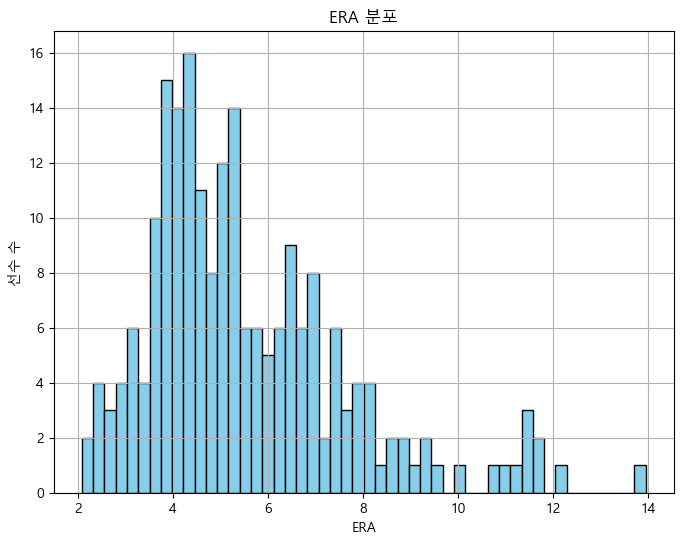

In [415]:
# ERA 분포
plt.figure(figsize=(8, 6))
plt.hist(pitcher['ERA'], bins=50, color='skyblue', edgecolor='black') 
plt.title('ERA 분포')
plt.xlabel('ERA')
plt.ylabel('선수 수')
plt.grid(True)
plt.show()

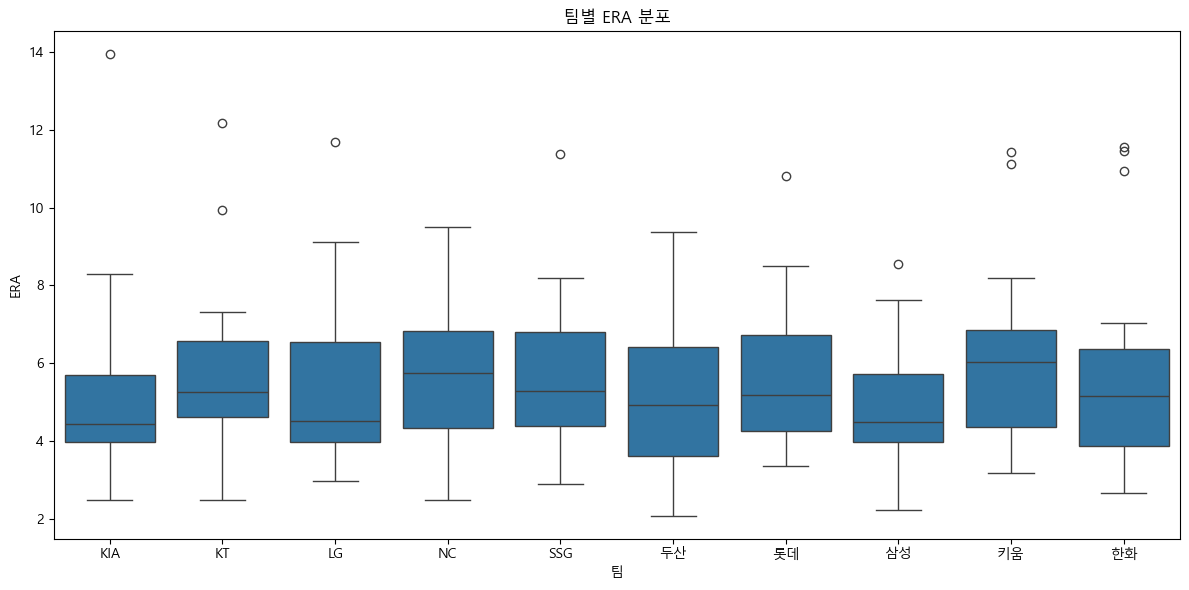

In [417]:
# 팀별 ERA 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='ERA', data=pitcher)
plt.title('팀별 ERA 분포')
plt.xlabel('팀')
plt.ylabel('ERA')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

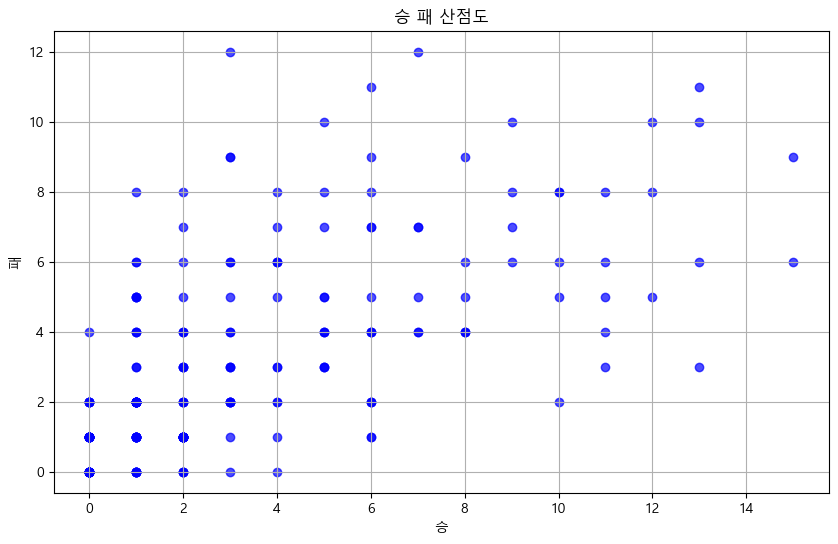

In [421]:
plt.figure(figsize=(10, 6))
plt.scatter(pitcher['W'], pitcher['L'], c='blue', label='Pitcher', alpha=0.7)

plt.title('승 패 산점도')
plt.xlabel('승')
plt.ylabel('패')

plt.grid(True)
plt.show()

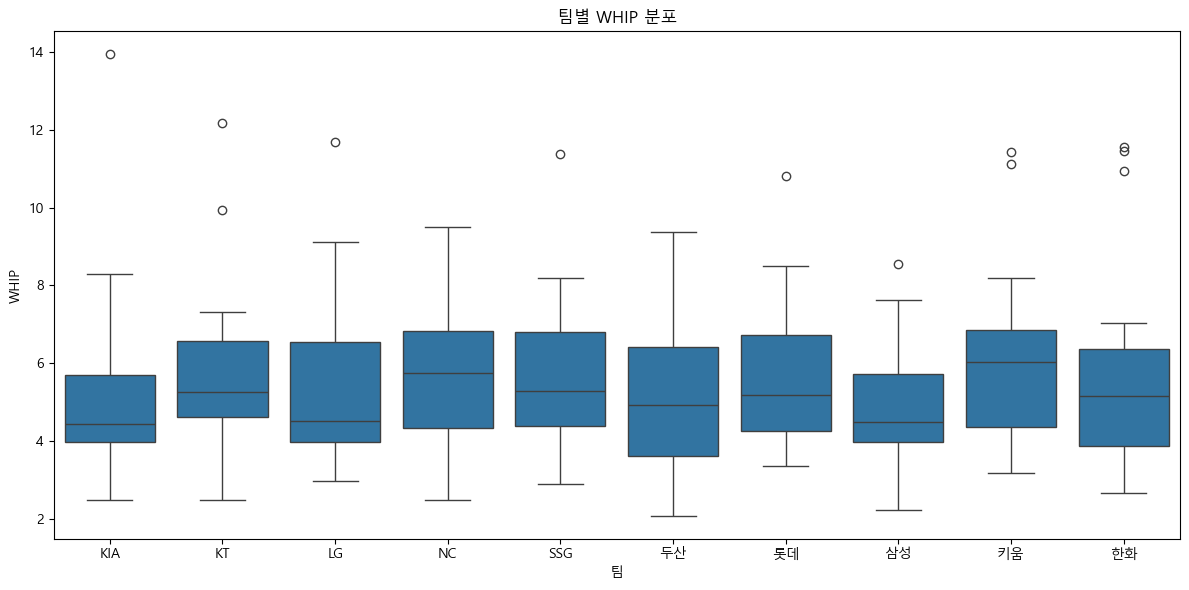

In [423]:
# 팀별 WHIP 분포
plt.figure(figsize=(12, 6))
sns.boxplot(x='Team', y='ERA', data=pitcher)
plt.title('팀별 WHIP 분포')
plt.xlabel('팀')
plt.ylabel('WHIP')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

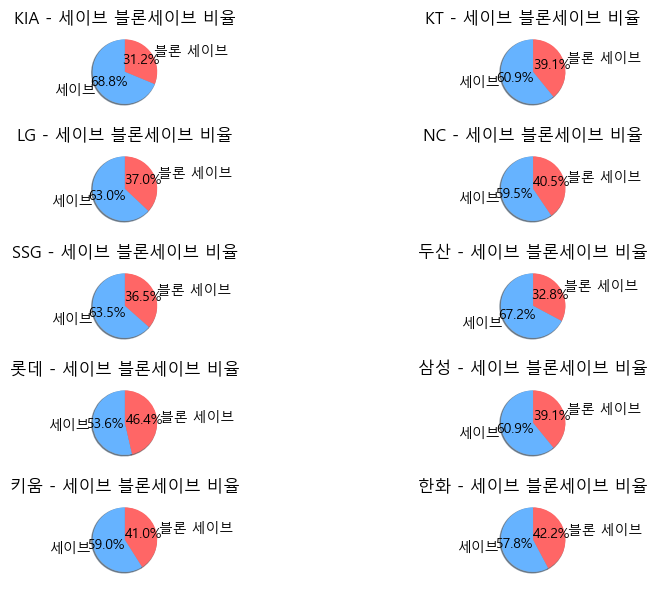

In [427]:
# 팀별 세이브, 블론세이브 비

team_saves = pitcher.groupby('Team')['SV'].sum()
team_blown_saves = pitcher.groupby('Team')['BSV'].sum()

teams = team_saves.index

plt.figure(figsize=(10, 6))

for i, team in enumerate(teams):
    save_count = team_saves[team]
    blown_save_count = team_blown_saves[team]
    labels = ['세이브', '블론 세이브']
    sizes = [save_count, blown_save_count]
    colors = ['#66b3ff', '#ff6666']
    
    plt.subplot(5, 2, i+1)
    plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title(f'{team} - 세이브 블론세이브 비율')

plt.tight_layout()
plt.show()

In [441]:
# 팀별 홀드 상위 선수 수

top_20_percent_hld = pitcher[pitcher['HLD'] >= pitcher['HLD'].quantile(0.8)]

top_20_percent_hld['Team'].value_counts()

Team
삼성     7
KIA    6
NC     5
SSG    5
LG     4
두산     4
한화     4
롯데     3
키움     3
KT     2
Name: count, dtype: int64

In [453]:
sp = pitcher[pitcher['IP']>80]
sp = sp[['Name', 'Team','G', 'ERA', 'W', 'L', 'IP', 'BB', 'SO', 'WHIP']]
sp

,Name,Team,G,ERA,W,L,IP,BB,SO,WHIP
3,네일,KIA,26,2.53,12,5,149.33,35,138,1.27
10,양현종,KIA,29,4.10,11,5,171.33,41,129,1.25
11,윤영철,KIA,18,4.19,7,4,81.67,43,58,1.53
12,황동하,KIA,25,4.44,5,7,103.33,44,81,1.48
34,쿠에바스,KT,31,4.10,7,12,173.33,59,154,1.25
37,벤자민,KT,28,4.63,11,8,149.67,48,156,1.26
38,엄상백,KT,29,4.88,13,10,156.67,42,159,1.31
40,고영표,KT,18,4.95,6,8,100.00,14,79,1.55
41,김민수,KT,75,5.20,5,3,81.33,33,75,1.44
61,손주영,LG,28,3.79,9,10,144.67,54,112,1.46


In [457]:
sp.sort_values(by='ERA', ascending=True)

,Name,Team,G,ERA,W,L,IP,BB,SO,WHIP
3,네일,KIA,26,2.53,12,5,149.33,35,138,1.27
87,하트,NC,26,2.69,13,3,157.00,38,182,1.03
118,노경은,SSG,77,2.90,8,5,83.67,32,71,1.23
172,반즈,롯데,25,3.35,9,6,150.67,46,171,1.23
231,후라도,키움,30,3.36,10,8,190.33,32,169,1.14
202,코너,삼성,28,3.43,11,6,160.00,40,158,1.09
203,원태인,삼성,28,3.66,15,6,159.67,42,119,1.20
233,헤이수스,키움,30,3.68,13,11,171.33,44,178,1.25
265,와이스,한화,16,3.73,5,5,91.67,29,98,1.16
61,손주영,LG,28,3.79,9,10,144.67,54,112,1.46


In [459]:
sp.sort_values(by='WHIP', ascending=True)

,Name,Team,G,ERA,W,L,IP,BB,SO,WHIP
87,하트,NC,26,2.69,13,3,157.00,38,182,1.03
202,코너,삼성,28,3.43,11,6,160.00,40,158,1.09
231,후라도,키움,30,3.36,10,8,190.33,32,169,1.14
265,와이스,한화,16,3.73,5,5,91.67,29,98,1.16
203,원태인,삼성,28,3.66,15,6,159.67,42,119,1.20
175,윌커슨,롯데,32,3.84,12,8,196.67,27,167,1.21
172,반즈,롯데,25,3.35,9,6,150.67,46,171,1.23
118,노경은,SSG,77,2.90,8,5,83.67,32,71,1.23
10,양현종,KIA,29,4.10,11,5,171.33,41,129,1.25
233,헤이수스,키움,30,3.68,13,11,171.33,44,178,1.25


In [461]:
entry_sp = ['원태인', '양현종', '노경은', '곽빈', '임찬규', '류현진']
# ERA, WHIP, 볼넷 삼진 비율 상위권

entry = entry + entry_sp

entry

['강민호',
 '양의지',
 '송성문',
 '문보경',
 '박민우',
 '김혜성',
 '김도영',
 '최정',
 '박성한',
 '박찬호',
 '구자욱',
 '박건우',
 '홍창기',
 '권희동',
 '원태인',
 '양현종',
 '노경은',
 '곽빈',
 '임찬규',
 '류현진']

In [467]:
rp = pitcher[pitcher['IP']<=80]
rp = rp[['Name', 'Team','G', 'ERA', 'W', 'L', 'SV', 'HLD', 'IP', 'BB', 'SO', 'WHIP']]
rp

,Name,Team,G,ERA,W,L,SV,HLD,IP,BB,SO,WHIP
2,정해영,KIA,53,2.49,2,3,31,1,50.67,16,50,1.24
4,곽도규,KIA,71,3.56,4,2,2,16,55.67,34,64,1.38
6,이준영,KIA,56,3.86,4,0,0,9,35.00,17,33,1.54
7,장현식,KIA,75,3.94,5,4,0,16,75.33,34,75,1.45
8,김승현,KIA,15,4.00,1,0,0,0,18.00,7,11,1.67
...,...,...,...,...,...,...,...,...,...,...,...,...
281,김기중,한화,27,6.56,5,4,0,0,59.00,27,39,1.86
282,김규연,한화,58,7.02,1,0,0,4,59.00,28,40,1.59
284,장지수,한화,13,10.93,0,0,0,0,14.00,10,11,2.36
285,한승주,한화,18,11.45,0,2,0,0,22.00,10,14,2.50


In [471]:
rp.sort_values(by='ERA', ascending=True).head(20)

,Name,Team,G,ERA,W,L,SV,HLD,IP,BB,SO,WHIP
143,김택연,두산,60,2.08,3,2,19,4,65.00,31,78,1.26
201,최지광,삼성,35,2.23,3,2,0,7,36.33,21,38,1.18
2,정해영,KIA,53,2.49,2,3,31,1,50.67,16,50,1.24
30,우규민,KT,45,2.49,4,1,1,4,43.33,2,39,1.13
86,김재열,NC,69,2.49,1,5,2,12,68.67,29,67,1.27
262,주현상,한화,65,2.65,8,4,23,2,71.33,8,64,0.84
145,홍건희,두산,65,2.73,4,3,9,11,59.33,33,45,1.48
146,이병헌,두산,77,2.89,6,1,1,22,65.33,34,57,1.45
57,유영찬,LG,62,2.97,7,5,26,1,63.67,30,77,1.43
147,김강률,두산,53,3.00,2,2,1,12,42.00,21,33,1.48


In [477]:
rp.sort_values(by='HLD', ascending=False).head(20)

,Name,Team,G,ERA,W,L,SV,HLD,IP,BB,SO,WHIP
207,임창민,삼성,60,3.98,2,1,1,28,54.33,30,50,1.66
63,김진성,LG,71,3.97,3,3,1,27,70.33,23,61,1.21
209,김재윤,삼성,65,4.09,4,8,11,25,66.00,25,51,1.26
206,김태훈,삼성,56,3.96,3,2,0,23,52.33,19,37,1.30
146,이병헌,두산,77,2.89,6,1,1,22,65.33,34,57,1.45
35,김민,KT,71,4.31,8,4,0,21,77.33,27,77,1.44
272,한승혁,한화,70,5.03,5,5,0,19,62.67,38,64,1.61
9,전상현,KIA,66,4.09,10,5,7,19,66.00,20,54,1.14
176,김상수,롯데,74,4.15,8,4,2,17,73.67,26,56,1.32
271,박상원,한화,65,4.59,3,3,2,16,66.67,22,65,1.19


In [479]:
rp.sort_values(by='SV', ascending=False).head(20)

,Name,Team,G,ERA,W,L,SV,HLD,IP,BB,SO,WHIP
2,정해영,KIA,53,2.49,2,3,31,1,50.67,16,50,1.24
215,오승환,삼성,58,4.91,3,9,27,2,55.00,18,42,1.69
57,유영찬,LG,62,2.97,7,5,26,1,63.67,30,77,1.43
33,박영현,KT,66,3.52,10,2,25,0,76.67,22,87,1.11
174,김원중,롯데,56,3.55,3,6,25,0,63.33,31,68,1.42
262,주현상,한화,65,2.65,8,4,23,2,71.33,8,64,0.84
123,문승원,SSG,62,4.50,6,1,20,6,60.00,24,53,1.52
143,김택연,두산,60,2.08,3,2,19,4,65.00,31,78,1.26
102,이용찬,NC,57,6.13,3,9,16,2,54.33,21,49,1.90
235,주승우,키움,55,4.35,4,6,14,5,51.67,18,43,1.32


In [483]:
rp.sort_values(by='WHIP', ascending=True).head(20)

,Name,Team,G,ERA,W,L,SV,HLD,IP,BB,SO,WHIP
262,주현상,한화,65,2.65,8,4,23,2,71.33,8,64,0.84
238,김동욱,키움,37,5.00,2,1,0,3,36.00,6,18,1.08
33,박영현,KT,66,3.52,10,2,25,0,76.67,22,87,1.11
30,우규민,KT,45,2.49,4,1,1,4,43.33,2,39,1.13
9,전상현,KIA,66,4.09,10,5,7,19,66.00,20,54,1.14
119,조병현,SSG,76,3.58,4,6,12,12,73.00,31,96,1.14
148,브랜든,두산,14,3.12,7,4,0,0,75.00,11,75,1.15
201,최지광,삼성,35,2.23,3,2,0,7,36.33,21,38,1.18
89,김영규,NC,42,3.15,4,2,1,14,45.67,14,48,1.18
271,박상원,한화,65,4.59,3,3,2,16,66.67,22,65,1.19


In [485]:
entry_rp = ['정해영', '김택연', '주현상', '박영현', '조병현', '전상현', '김진성', '김재열']
# 정해영 : ERA 매우 낮음, 세이브 많음
# 김택연 : ERA 매우 낮음
# 주현상 : ERA, WHIP 매우 낮음, 세이브 많음
# 박영현 : WHIP 매우 낮음, 세이브 많음
# 조병현 : 홀드, 세이브 많음, WHIP 낮음
# 전상현 : 홀드 많음, WHIP 낮음
# 김진성 : 세이브 많음, WHIP 낮음
# 김재열 : ERA 매우 낮음, WHIP 낮음

entry = entry + entry_rp

entry

['강민호',
 '양의지',
 '송성문',
 '문보경',
 '박민우',
 '김혜성',
 '김도영',
 '최정',
 '박성한',
 '박찬호',
 '구자욱',
 '박건우',
 '홍창기',
 '권희동',
 '원태인',
 '양현종',
 '노경은',
 '곽빈',
 '임찬규',
 '류현진',
 '정해영',
 '김택연',
 '주현상',
 '박영현',
 '조병현',
 '전상현',
 '김진성',
 '김재열']

In [499]:
entry_hitter = hitter[hitter['Name'].isin(entry)]
entry_hitter = entry_hitter[['Name', 'Team','POS', 'G', 'AVG', 'OBP', 'SLG', 'HR', 'RBI', 'BB_to_SO', 'SB_1', 'RISP']]
entry_hitter = entry_hitter.drop_duplicates()

entry_hitter

,Name,Team,POS,G,AVG,OBP,SLG,HR,RBI,BB_to_SO,SB_1,RISP
0,김도영,KIA,3루수,141,0.347,0.420,0.647,38,109,0.600000,40,0.317
7,박찬호,KIA,유격수,134,0.307,0.363,0.386,5,61,1.090909,20,0.359
34,홍창기,LG,우익수,139,0.336,0.447,0.410,5,73,1.032258,10,0.389
38,문보경,LG,3루수,144,0.301,0.372,0.507,22,101,0.580357,7,0.292
39,문보경,LG,1루수,144,0.301,0.372,0.507,22,101,0.580357,7,0.292
51,박건우,NC,우익수,89,0.344,0.409,0.542,13,53,0.611111,4,0.375
52,박민우,NC,2루수,121,0.328,0.406,0.446,8,50,0.683544,32,0.314
54,권희동,NC,좌익수,123,0.300,0.417,0.452,13,77,1.222222,4,0.391
76,박성한,SSG,유격수,137,0.301,0.380,0.411,10,67,0.744186,13,0.302
77,최정,SSG,3루수,129,0.291,0.384,0.594,37,107,0.482456,5,0.284


In [501]:
entry_hitter.sort_values(by='OBP', ascending=False)

,Name,Team,POS,G,AVG,OBP,SLG,HR,RBI,BB_to_SO,SB_1,RISP
34,홍창기,LG,우익수,139,0.336,0.447,0.410,5,73,1.032258,10,0.389
0,김도영,KIA,3루수,141,0.347,0.420,0.647,38,109,0.600000,40,0.317
54,권희동,NC,좌익수,123,0.300,0.417,0.452,13,77,1.222222,4,0.391
129,구자욱,삼성,좌익수,129,0.343,0.417,0.627,33,115,0.753425,13,0.341
51,박건우,NC,우익수,89,0.344,0.409,0.542,13,53,0.611111,4,0.375
150,송성문,키움,3루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
151,송성문,키움,1루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
52,박민우,NC,2루수,121,0.328,0.406,0.446,8,50,0.683544,32,0.314
77,최정,SSG,3루수,129,0.291,0.384,0.594,37,107,0.482456,5,0.284
154,김혜성,키움,2루수,127,0.326,0.383,0.458,11,75,0.758065,30,0.377


In [503]:
entry_hitter.sort_values(by='AVG', ascending=False)

,Name,Team,POS,G,AVG,OBP,SLG,HR,RBI,BB_to_SO,SB_1,RISP
0,김도영,KIA,3루수,141,0.347,0.420,0.647,38,109,0.600000,40,0.317
51,박건우,NC,우익수,89,0.344,0.409,0.542,13,53,0.611111,4,0.375
129,구자욱,삼성,좌익수,129,0.343,0.417,0.627,33,115,0.753425,13,0.341
150,송성문,키움,3루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
151,송성문,키움,1루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
34,홍창기,LG,우익수,139,0.336,0.447,0.410,5,73,1.032258,10,0.389
52,박민우,NC,2루수,121,0.328,0.406,0.446,8,50,0.683544,32,0.314
154,김혜성,키움,2루수,127,0.326,0.383,0.458,11,75,0.758065,30,0.377
93,양의지,두산,포수,119,0.314,0.379,0.479,17,94,0.714286,2,0.393
7,박찬호,KIA,유격수,134,0.307,0.363,0.386,5,61,1.090909,20,0.359


In [505]:
entry_hitter.sort_values(by='SLG', ascending=False)

,Name,Team,POS,G,AVG,OBP,SLG,HR,RBI,BB_to_SO,SB_1,RISP
0,김도영,KIA,3루수,141,0.347,0.420,0.647,38,109,0.600000,40,0.317
129,구자욱,삼성,좌익수,129,0.343,0.417,0.627,33,115,0.753425,13,0.341
77,최정,SSG,3루수,129,0.291,0.384,0.594,37,107,0.482456,5,0.284
51,박건우,NC,우익수,89,0.344,0.409,0.542,13,53,0.611111,4,0.375
150,송성문,키움,3루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
151,송성문,키움,1루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
38,문보경,LG,3루수,144,0.301,0.372,0.507,22,101,0.580357,7,0.292
39,문보경,LG,1루수,144,0.301,0.372,0.507,22,101,0.580357,7,0.292
131,강민호,삼성,포수,136,0.303,0.365,0.496,19,77,0.673077,3,0.274
93,양의지,두산,포수,119,0.314,0.379,0.479,17,94,0.714286,2,0.393


In [507]:
entry_hitter.sort_values(by='RISP', ascending=False)

,Name,Team,POS,G,AVG,OBP,SLG,HR,RBI,BB_to_SO,SB_1,RISP
93,양의지,두산,포수,119,0.314,0.379,0.479,17,94,0.714286,2,0.393
54,권희동,NC,좌익수,123,0.300,0.417,0.452,13,77,1.222222,4,0.391
34,홍창기,LG,우익수,139,0.336,0.447,0.410,5,73,1.032258,10,0.389
154,김혜성,키움,2루수,127,0.326,0.383,0.458,11,75,0.758065,30,0.377
51,박건우,NC,우익수,89,0.344,0.409,0.542,13,53,0.611111,4,0.375
150,송성문,키움,3루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
151,송성문,키움,1루수,142,0.340,0.409,0.518,19,104,0.780488,21,0.372
7,박찬호,KIA,유격수,134,0.307,0.363,0.386,5,61,1.090909,20,0.359
129,구자욱,삼성,좌익수,129,0.343,0.417,0.627,33,115,0.753425,13,0.341
0,김도영,KIA,3루수,141,0.347,0.420,0.647,38,109,0.600000,40,0.317


In [ ]:
# 1번 : 홍창기. 출루율 제일 높고, 주루도 괜찮고, 볼넷삼진 비율이 좋다.
# 2번 : 송성문. 타율 높고, 주루 좋다.
# 3번 : 구자욱. 타율, 장타율 매우 높다.
# 4번 : 김도영. 모든 지표 매우 높다.
# 5번 : 양의지. 득점권 타율이 제일 높다.
# 6번 : 박건우. 지표 모두 좋고 득점권 타율 높다.
# 7번 : 김혜성. 박민우보다 볼넷삼진비울이나 득점권 타율이 높다.
# 8번 : 타율, 출루율, 득점권 타율이 낮다. 박성한 보다 장타율이 좋다.
# 9번 : 박성한. 박찬호보다 출루율, 장타율이 좋다. 다른 타자들보다 기록이 안 좋고 득점권 타율이 낮다.